# Local biases in specific hot-humid and hot-dry regions
- It is revealing to explore the bias structure in a more detailed way for two different end-member regimes relevant to heat stress, corresponding to hot-humid and hot-dry climates.

- Here Bangladesh and Sahara (Amazon and Arabia) are selected for assessing the bias of sWBGT (ESI). Each region is characterized by a 2° x 2° lat/lon box. Hourly ERA5 reanalysis data during 1990-2019 are used for calculation. Since we focus on heat stress, only the hottest calendar month is included.

- In this notebook, we will reproduce Figure 6 in "Explicit Calculations of Wet Bulb Globe Temperature compared with approximations and why it matters for labor productivity" by Qinqin Kong and Matthew Huber. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Read in data:
We read in the following files:
- ```Bangladesh_daytime.nc``` which contains:
     - ```WBGT```: daytime WBGT at Bangladesh
     - ```sWBGT_bias```: daytime sWBGT biases at Bangladesh
     - ```rsds```: daytime solar radiation at Bangladesh
- ```Bangladesh_nighttime.nc``` which contains:
     - ```WBGT```: nighttime WBGT at Bangladesh
     - ```sWBGT_bias```: nighttime sWBGT biases at Bangladesh
- ```Bangladesh_diurnal_cycle.nc``` which contains:
     - ```swbgt_bias_mean```: diurnal cycle of mean sWBGT biases at Bangladesh
     - ```swbgt_bias_q01```: diurnal cycle of 1th percentile of sWBGT biases at Bangladesh
     - ```swbgt_bias_q99```: diurnal cycle of 99th percentile of sWBGT biases at Bangladesh
- ```Sahara_daytime.nc``` which contains:
     - ```WBGT```: daytime WBGT at Sahara
     - ```sWBGT_bias```: daytime sWBGT biases at Sahara
     - ```rsds```: daytime solar radiation at Sahara
- ```Sahara_nighttime.nc``` which contains:
     - ```WBGT```: nighttime WBGT at Sahara
     - ```sWBGT_bias```: nighttime sWBGT biases at Sahara
- ```Sahara_diurnal_cycle.nc``` which contains:
     - ```swbgt_bias_mean```: diurnal cycle of mean sWBGT biases at Sahara
     - ```swbgt_bias_q01```: diurnal cycle of 1th percentile of sWBGT biases at Sahara
     - ```swbgt_bias_q99```: diurnal cycle of 99th percentile of sWBGT biases at Sahara
- ```Amazon_daytime.nc``` which contains:
     - ```WBGT```: daytime WBGT at Amazon
     - ```ESI_bias```: daytime ESI biases at Amazon
     - ```rsds```: daytime solar radiation at Amazon
- ```Amazon_nighttime.nc``` which contains:
     - ```WBGT```: nighttime WBGT at Amazon
     - ```ESI_bias```: nighttime ESI biases at Amazon
- ```Amazon_diurnal_cycle.nc``` which contains:
     - ```esi_bias_mean```: diurnal cycle of mean ESI biases at Amazon
     - ```esi_bias_q01```: diurnal cycle of 1th percentile of ESI biases at Amazon
     - ```esi_bias_q99```: diurnal cycle of 99th percentile of ESI biases at Amazon
- ```Arabia_daytime.nc``` which contains:
     - ```WBGT```: daytime WBGT at Arabia
     - ```ESI_bias```: daytime ESI biases at Arabia
     - ```rsds```: daytime solar radiation at Arabia
- ```Arabia_nighttime.nc``` which contains:
     - ```WBGT```: nighttime WBGT at Arabia
     - ```ESI_bias```: nighttime ESI biases at Arabia
- ```Arabia_diurnal_cycle.nc``` which contains:
     - ```esi_bias_mean```: diurnal cycle of mean ESI biases at Arabia
     - ```esi_bias_q01```: diurnal cycle of 1th percentile of ESI biases at Arabia
     - ```esi_bias_q99```: diurnal cycle of 99th percentile of ESI biases at Arabia
- ```heatmap.nc``` which contains:
     - ```Bangladesh```: 2D frequency array with WBGT on the x-axis and sWBGT biases on the y-axis for Bangladesh
     - ```Sahara```: 2D frequency array with WBGT on the x-axis and sWBGT biases on the y-axis for Sahara
     - ```Amazon```: 2D frequency array with WBGT on the x-axis and ESI biases on the y-axis for Amazon
     - ```Arabia```: 2D frequency array with WBGT on the x-axis and ESI biases on the y-axis for Arabia

In [3]:
# read in data
Bangladesh_daytime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Bangladesh_daytime.nc')
Bangladesh_nighttime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Bangladesh_nighttime.nc')
Bangladesh_diurnal_cycle=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Bangladesh_diurnal_cycle.nc')

Sahara_daytime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Sahara_daytime.nc')
Sahara_nighttime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Sahara_nighttime.nc')
Sahara_diurnal_cycle=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Sahara_diurnal_cycle.nc')

Amazon_daytime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Amazon_daytime.nc')
Amazon_nighttime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Amazon_nighttime.nc')
Amazon_diurnal_cycle=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Amazon_diurnal_cycle.nc')

Arabia_daytime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Arabia_daytime.nc')
Arabia_nighttime=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Arabia_nighttime.nc')
Arabia_diurnal_cycle=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/Arabia_diurnal_cycle.nc')

freq=xr.open_dataset('/scratch/brown/kong97/paper_data/geohealth_2021/heatmap.nc')

In [12]:
# scatter plot function for daytime
def scatter_plot_daytime(axis,x,y,c,xlabel,ylabel,metric,colorbar):
    cmap=cmaps.sunshine_diff_12lev
    g=axis.scatter(x,y,c=c,s=0.2,alpha=0.5,rasterized=True,cmap=cmap,vmin=10,vmax=1040)
    axis.set_xlim(10, 42)
    axis.set_ylim(-12,12)
    axis.boxplot(y,sym='',positions=[40],whis=(1, 99),widths=3) # add boxplot
    axis.axhline(y=0,lw=0.8,color='k')
    if xlabel: # control if add label and ticks on x-axis
        axis.set_xlabel('WBGT ($^\circ$C)',fontsize=12)
        axis.set_xticks([10,20,30,40])
        axis.set_xticklabels(('10', '20', '30','40'))
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    if ylabel: # control if add label and ticks on y-axis
        if metric=='sWBGT': # control which metric to plot
            axis.set_ylabel('sWBGT-WBGT ($^\circ$C)',fontsize=12)
        else:
            axis.set_ylabel('ESI-WBGT ($^\circ$C)',fontsize=12)
        axis.set_yticks([-10,-5,0,5,10])
    else:
        axis.set_yticks([])
        axis.set_ylabel('')
    axis.tick_params(axis='both', which='major', labelsize=12)
    if colorbar: # control if plot color bar
        cbaxes = inset_axes(axis, width="4%", height="25%", loc=3) 
        plt.colorbar(g,cax=cbaxes, ticks=[10,1040])
               
# scatter plot function for nighttime
def scatter_plot_nighttime(axis,x,y,xlabel,ylabel,metric):
    axis.scatter(x,y,s=0.2,alpha=0.5,rasterized=True,color='k')
    axis.set_xlim(10, 42)
    axis.set_ylim(-12,12)
    axis.boxplot(y,sym='',positions=[40],whis=(1, 99),widths=3)
    axis.axhline(y=0,lw=0.8,color='k')
    if xlabel:
        axis.set_xlabel('WBGT ($^\circ$C)',fontsize=12)
        axis.set_xticks([10,20,30,40])
        axis.set_xticklabels(('10', '20', '30','40'))
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    if ylabel:
        if metric=='sWBGT':
            axis.set_ylabel('sWBGT-WBGT ($^\circ$C)',fontsize=12)
        else:
            axis.set_ylabel('ESI-WBGT ($^\circ$C)',fontsize=12)
        axis.set_yticks([-10,-5,0,5,10])
    else:
        axis.set_yticks([])
        axis.set_ylabel('')
    axis.tick_params(axis='both', which='major', labelsize=12)  

# heatmap function to show the frequency distribution    
def heatmap(axis,x,y,data,cmap,norm,xlabel):
    g=axis.pcolormesh(x,y,data,cmap=cmap,norm=norm)
    axis.set_yticks([])
    axis.set_ylabel('')
    axis.set_xlim(10, 42)
    axis.set_ylim(-12,12)
    if xlabel:
        axis.set_xlabel('WBGT ($^\circ$C)',fontsize=12)
        axis.set_xticks([10,20,30,40])
        axis.set_xticklabels(('10', '20', '30','40'))
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    return g

# plot the diurnal cycle
def line_plot(axis,x,y,y01,y99,xlabel,ylabel,metric):
    axis.plot(x,y,linewidth=2,color='black')
    axis.fill_between(x,y01,y99,alpha=0.2,color='black')
    if xlabel:
        axis.set_xlabel('Hours',fontsize=12)
        axis.set_xticks([0,4,8,12,16,20,24])
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    if ylabel:
        if metric=='sWBGT':
            axis.set_ylabel('sWBGT-WBGT ($^\circ$C)',fontsize=12)
        else:
            axis.set_ylabel('ESI-WBGT ($^\circ$C)',fontsize=12)
        axis.set_ylim(-12,12)
        axis.set_yticks([-10,-5,0,5,10])
    else:
        axis.set_yticks([])
        axis.set_ylabel('')
    axis.tick_params(axis='both', which='major', labelsize=12)

# make the whole plot    
def plot(Bangladesh_diurnal_cycle, Sahara_diurnal_cycle,Amazon_diurnal_cycle,Arabia_diurnal_cycle,
         Bangladesh_daytime,Bangladesh_nighttime,Sahara_daytime,Sahara_nighttime,
         Amazon_daytime,Amazon_nighttime,Arabia_daytime,Arabia_nighttime, freq):
    
    # create a figure and add axis
    fig, ([ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]) = plt.subplots(4,4,figsize=[15, 10])

    # adjust relative positions of subplots
    fig.subplots_adjust(wspace=0.1,hspace=0.3)
    # add annotates
    anno_opts = dict(xy=(0, 1.1), xycoords='axes fraction',va='center', ha='center')
    num=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
    i=0
    for axis in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16):
        axis.annotate(num[i], **anno_opts,fontsize=14)
        i+=1
    
    # plot diurnal cycle for sWBGT at Bangladesh
    line_plot(ax1,Bangladesh_diurnal_cycle.hour,Bangladesh_diurnal_cycle.swbgt_bias_mean,
              Bangladesh_diurnal_cycle.swbgt_bias_q01,Bangladesh_diurnal_cycle.swbgt_bias_q99,False,True,'sWBGT')
    
    # scatter plot for daytime at Bangladesh
    scatter_plot_daytime(ax2,Bangladesh_daytime.WBGT,Bangladesh_daytime.sWBGT_bias,Bangladesh_daytime.rsds,False,False,'sWBGT',False)
    # scatter plot for nighttime at Bangladesh
    scatter_plot_nighttime(ax3,Bangladesh_nighttime.WBGT,Bangladesh_nighttime.sWBGT_bias,False,False,'sWBGT')

    # set colorbar scale
    levels=[0,0.01,0.05,0.1,0.5,1,2,3,4,6,10]
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels),extend='max')
    # we pick colors from different colormaps, create a new color list, and then create a customized colormap from this new color list
    color=cmaps.sunshine_diff_12lev.colors
    color_new=np.concatenate((color[1:6],color[7:]))
    cmap=mpl.colors.ListedColormap(color_new)
    
    # heat map for sWBGT biases at Bangladesh
    X=np.arange(10,42.1,1)
    Y=np.arange(-12,12.1,1)
    heatmap(ax4,X,Y,freq.Bangladesh,cmap,norm,False)
    
    # plot diurnal cycle for sWBGT at Sahara
    line_plot(ax5,Sahara_diurnal_cycle.hour,Sahara_diurnal_cycle.swbgt_bias_mean,
              Sahara_diurnal_cycle.swbgt_bias_q01,Sahara_diurnal_cycle.swbgt_bias_q99,False,True,'sWBGT')
    # scatter plot for daytime at Sahara
    scatter_plot_daytime(ax6,Sahara_daytime.WBGT,Sahara_daytime.sWBGT_bias,Sahara_daytime.rsds,False,False,'sWBGT',False)
    # scatter plot for nighttime at Sahara
    scatter_plot_nighttime(ax7,Sahara_nighttime.WBGT,Sahara_nighttime.sWBGT_bias,False,False,'sWBGT')
    # heat map for sWBGT biases at Sahara
    heatmap(ax8,X,Y,freq.Sahara,cmap,norm,False)
    
    # plot diurnal cycle for ESI at Amazon
    line_plot(ax9,Amazon_diurnal_cycle.hour,Amazon_diurnal_cycle.esi_bias_mean,
              Amazon_diurnal_cycle.esi_bias_q01,Amazon_diurnal_cycle.esi_bias_q99,False,True,'ESI')
    # scatter plot for daytime at Amazon
    scatter_plot_daytime(ax10,Amazon_daytime.WBGT,Amazon_daytime.ESI_bias,Amazon_daytime.rsds,False,False,'ESI',False)
    # scatter plot for nighttime at Amazon
    scatter_plot_nighttime(ax11,Amazon_nighttime.WBGT,Amazon_nighttime.ESI_bias,False,False,'ESI')
    # heat map for ESI biases at Amazon
    heatmap(ax12,X,Y,freq.Amazon,cmap,norm,False)

    # plot diurnal cycle for ESI at Arabia
    line_plot(ax13,Arabia_diurnal_cycle.hour,Arabia_diurnal_cycle.esi_bias_mean,Arabia_diurnal_cycle.esi_bias_q01,Arabia_diurnal_cycle.esi_bias_q99,True,True,'ESI')
    # scatter plot for daytime at Arabia
    scatter_plot_daytime(ax14,Arabia_daytime.WBGT,Arabia_daytime.ESI_bias,Arabia_daytime.rsds,True,False,'ESI',True)
    # scatter plot for nighttime at Arabia
    scatter_plot_nighttime(ax15,Arabia_nighttime.WBGT,Arabia_nighttime.ESI_bias,True,False,'ESI')
    # heat map for ESI biases at Arabia
    h=heatmap(ax16,X,Y,freq.Arabia,cmap,norm,True)
    
    # plot colorbar
    cb=fig.colorbar(h,ax=((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)),orientation='vertical', pad=0.03,shrink=0.7,fraction=.09,ticks=[0,0.01,0.05,0.1,0.5,1,2,3,4,6,10],
                    aspect=30) 
    cb.ax.set_yticklabels(['0', '0.01', '0.05','0.1','0.5','1','2','3','4','6','10'])
    cb.set_label(label="Frequency (%)", size=12)
    cb.ax.tick_params(labelsize=12)
    
    

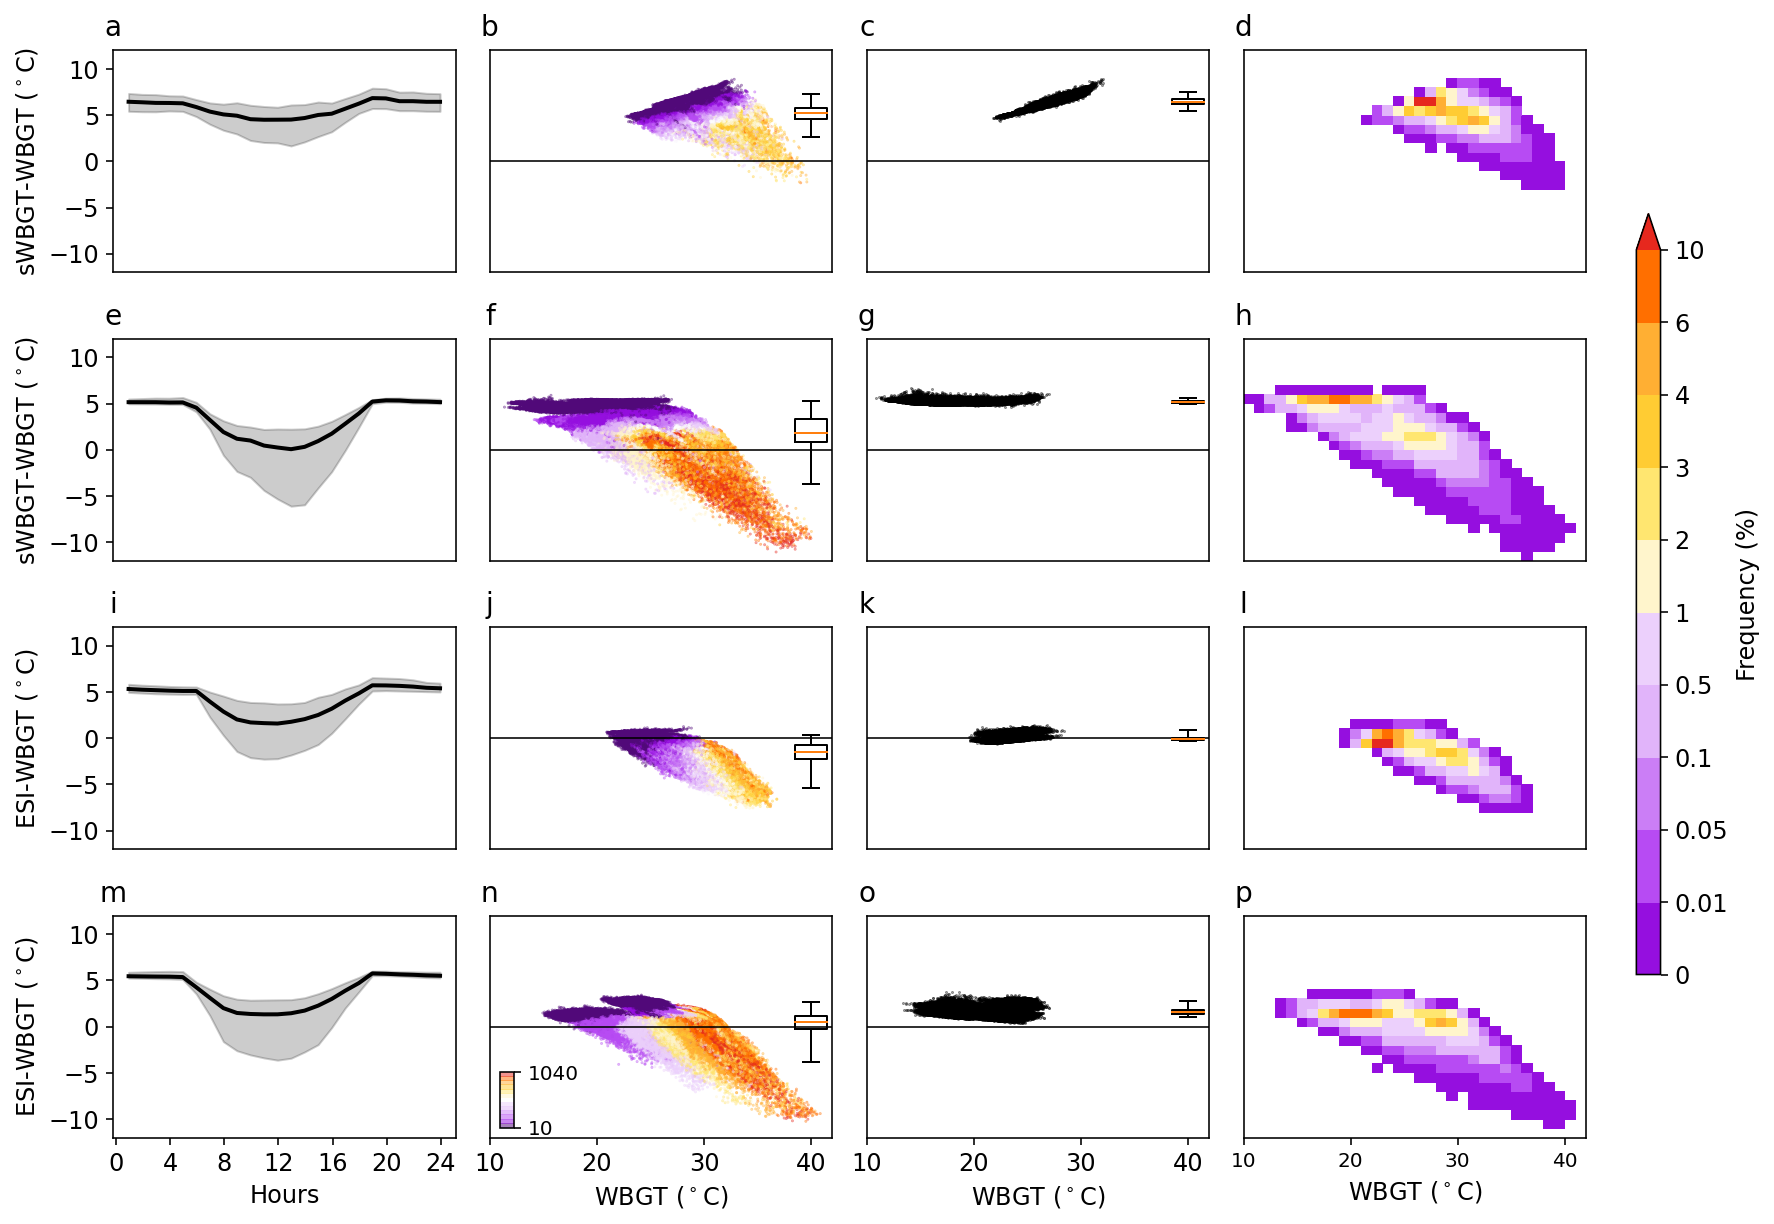

In [13]:
plot(Bangladesh_diurnal_cycle, Sahara_diurnal_cycle,Amazon_diurnal_cycle,Arabia_diurnal_cycle,
     Bangladesh_daytime,Bangladesh_nighttime,Sahara_daytime,Sahara_nighttime,
     Amazon_daytime,Amazon_nighttime,Arabia_daytime,Arabia_nighttime, freq)

### Figure caption:
Biases quantification for sWBGT over Bangladesh (23-25$^\circ$N; 88-90$^\circ$E) (a-d) and Sahara (22-24$^\circ$N; 24-26$^\circ$E) (e-h), and ESI over Amazon (1$^\circ$S-1$^\circ$N; 70-72$^\circ$W) (i-l) and Arabia (25-27$^\circ$N; 43-45$^\circ$E) (m-p). The diurnal cycle of biases is plotted in the leftmost column, with the shading area corresponding to 1 to 99th percentiles. Bias scattergrams for daytime and nighttime are plotted in the middle two columns with daytime on the left and nighttime on the right. Boxplots placed within scattergram describe bias spread with box extending from the lower to upper quartile and whiskers representing 1th and 99th percentiles. Daytime scattergram is colored by surface downward solar radiation. Bias frequency heatmap for both daytime and nighttime is plotted in the rightmost column. Data used cover the period 1990-2019 with only the hottest calendar month (defined by climatological monthly average WBGT) included.

# Findings
- Biases of sWBGT exhibit similar diurnal cycles at Bangladesh and Sahara with larger positive biases during nighttime and smaller biases during mid-day.
- sWBGT rarely underestimates WBGT in Bangladesh within hot-humid climate. Sahara, being hot and dry, sees both positive and negative biases in daytime with the majority of cases being positive biases. 
- ESI also shows similar diurnal cycles of biases over Amazon and Arabia with smaller biases in nighttime especially for Amazon. During nighttime in Arabia, ESI consistently overestimates WBGT by around 2°C potentially as a result of low humidity. 
- A negative correlation between daytime biases and WBGT values is identified for both metrics. This negative correlation indicates a serious underestimation of extreme heat stress by sWBGT at Sahara and by ESI at both Amazon and Arabia. 
- Solar radiation appears to be negatively (positively) correlated with biases (WBGT) confirming its important role in contributing to the negative correlation between biases and WBGT values. 
- Hot-dry regions have more dispersed bias distribution than hot-humid regions. Bias spread is also much larger during daytime potentially as a result of the large spatial and temporal variability in short-wave radiation. 